In [121]:
# Importação das bibliotecas
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ConfusionMatrix
import psycopg2
import scipy.stats
import statistics as sts
import seaborn as srn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report


from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils




ImportError: cannot import name 'np_utils' from 'keras.utils' (C:\Users\adeni\anaconda3\Lib\site-packages\keras\utils\__init__.py)

In [122]:
#Testa a conexão com o banco de dados
try:
    connection = psycopg2.connect(
        dbname="FirstJob",
        user="postgres",
        password="carol8513",
        host="localhost",
        port="5433"
    )
    cursor = connection.cursor()
    cursor.execute("SELECT 1;")
    print("Conectado com sucesso!")
except Exception as e:
    print(f"Erro ao conectar: {e}")


Conectado com sucesso!


In [123]:
#Verifica as tabelas públicas existentes no servidor
cursor.execute("SELECT tablename FROM pg_tables WHERE schemaname = 'public';")
tables = cursor.fetchall()
for table in tables:
    print(table[0])

CLIENTES
CREDITO
EMPREGO
ESTADOCIVIL
FIADOR
HABITACAO
HISTORICO_CREDITO
INVESTIMENTOS
OUTROSFINANC
PROFISSAO
PROPOSITO


In [124]:
# Agora iremos fazer a análise exploratória dos dados e buscar inconsistências nos dados
# Começando por CLIENTES
cursor.execute('SELECT * FROM "CLIENTES";')
rows = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
clientes = pd.DataFrame(rows, columns=colnames)
clientes 




,idcliente,cliente,estado,sexo
0,1,Adelina Buenaventura,RJ,M
1,2,Adelino Gago,RJ,M
2,3,Adélio Lisboa,SE,M
3,4,Adérito Bahía,MA,M
4,5,Adolfo Patrício,PE,M
...,...,...,...,...
245,246,Jandaíra Albuquerque,SP,F
246,247,Joana Ataí,GO,F
247,248,Joaquim Hurtado,AP,M
248,249,Joaquim Mieiro,TO,M


In [125]:
#Verificando a lista de estados
estados = clientes.groupby(['estado']).size()


In [126]:
#Usando descibre, recuperamos uma lista com as métricas dos dados e recuperamos os valores max e min
#Com isso, recuperamos o estado que mais apareceu no conjunto, ou seja, a moda
#A partir disso, podemos verificar se há alguma sigla de estado errada e substituir o eventual valor pela moda
desc_estados = list(scipy.stats.describe(estados))
_, moda = desc_estados[1]



In [127]:
#Sabendo o valor da moda, podemos transformar  o agrupamento de estados em um dicionário
#Fazemos um loop por cada key,value e verificamos qual value é igual a moda
#Se o valor for igual a moda, definimos qual chave representa esta moda
estados_dict = dict(estados)
estado_moda = ""

for estado,valor in estados_dict.items():
    if valor == moda:
        estado_moda = estado
        break

print(estados_dict)

{'AC': 14, 'AL': 8, 'AM': 12, 'AP': 8, 'BA': 14, 'CE': 9, 'DF': 7, 'ES': 6, 'GO': 7, 'MA': 9, 'MG': 9, 'MS': 8, 'MT': 4, 'PA': 13, 'PB': 10, 'PE': 6, 'PI': 13, 'PR': 5, 'RJ': 12, 'RN': 13, 'RO': 9, 'RR': 10, 'RS': 7, 'SC': 14, 'SE': 6, 'SP': 9, 'TO': 8}


In [128]:
siglas = ["AC", "AL", "AP", "AM", "BA", "CE", "DF", "ES", 
          "GO", "MA", "MT", "MS", "MG", "PA", "PB", "PR", "PE", "PI", "RJ", 
          "RN", "RS", "RO", "RR", "SC", "SP", "SE", "TO"]

keys_to_replace = []

# Encontra as chaves erradas
for estado in estados_dict.keys():
    if estado not in siglas:
        keys_to_replace.append(estado)

# Remove as chaves erradas e adiciona estes valores ao estado moda
for key in keys_to_replace:
    estados_dict[estado_moda] = estados_dict[estado_moda] + estados_dict[key]
    estados_dict.pop(key)

print(estados_dict)

{'AC': 14, 'AL': 8, 'AM': 12, 'AP': 8, 'BA': 14, 'CE': 9, 'DF': 7, 'ES': 6, 'GO': 7, 'MA': 9, 'MG': 9, 'MS': 8, 'MT': 4, 'PA': 13, 'PB': 10, 'PE': 6, 'PI': 13, 'PR': 5, 'RJ': 12, 'RN': 13, 'RO': 9, 'RR': 10, 'RS': 7, 'SC': 14, 'SE': 6, 'SP': 9, 'TO': 8}


In [129]:
#Checndo problemas com as siglas dos sexos
sexos = clientes.groupby(['sexo']).size()
sexos

sexo
F    120
M    130
dtype: int64

In [130]:
#Análise da moda dos sexos, para substituição dos errados pela moda
desc_sexos = list(scipy.stats.describe(sexos))
_, moda = desc_sexos[1]
print(moda)

130


In [131]:
#Determinação da singla padrão da moda
sexos_dict = dict(sexos)
sexos_moda = ""

for sexo,valor in sexos_dict.items():
    if valor == moda:
        sexos_moda = sexo
        break

print(sexos_moda)

M


In [132]:
siglas = ["F", "M"]

keys_to_replace = []

# Encontra as chaves erradas
for sexo in sexos_dict.keys():
    if sexo not in siglas:
        keys_to_replace.append(sexo)

# Remove as chaves erradas e adiciona estes valores ao estado moda
for key in keys_to_replace:
    sexos_dict[sexos_moda] = sexos_dict[sexos_moda] + sexos_dict[key]
    sexos_dict.pop(key)

print(sexos_dict)

{'F': 120, 'M': 130}


In [133]:
#Visualização dos dados de fiador
cursor.execute('SELECT * FROM "FIADOR";')
rows = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
fiador = pd.DataFrame(rows, columns=colnames)
fiador 

,IDFIADOR,FIADOR
0,1,co aplicante
1,2,co requerente
2,3,nao
3,4,sim


In [134]:
#Visualização dos dados de histórico de crédito
cursor.execute('SELECT * FROM "HISTORICO_CREDITO";')
rows = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
hist_cred = pd.DataFrame(rows, columns=colnames)
hist_cred 

,IDHISTCRED,HISTORICO
0,1,Critico-outros creditos
1,2,existentes/pagos
2,3,Atrasos anteriores
3,4,sem creditos/todos pagos
4,5,todos pagos


In [135]:
#Visualização dos dados de histórico de estado civil
cursor.execute('SELECT * FROM "ESTADOCIVIL";')
rows = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
estad_civil = pd.DataFrame(rows, columns=colnames)
estad_civil

,IDESTADOCIVIL,ESTADOCIVIL
0,1,feminino div/dep/cas
1,2,maculino div/dep
2,3,masculino cas/viu
3,4,masculino solteiro


In [136]:
#Visualização dos dados de habitação
cursor.execute('SELECT * FROM "PROPOSITO";')
rows = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
proposito = pd.DataFrame(rows, columns=colnames)
proposito 

,IDPROPOSITO,PROPOSITO
0,1,reforma
1,2,educacao
2,3,moveis
3,4,veiculo novo
4,5,veiculo usado
5,6,abrir negocio
6,7,quitar divida
7,8,reforma casa
8,9,outros
9,10,qualificacao


In [137]:
#Visualização dos dados de habitação
cursor.execute('SELECT * FROM "HABITACAO";')
rows = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
habita = pd.DataFrame(rows, columns=colnames)
habita 

,IDHABITACAO,HABITACAO
0,1,proria
1,2,de graca
2,3,alugada


In [138]:
#Visualização dos dados de profissão
connection.rollback()
cursor.execute('SELECT * FROM "PROFISSAO";')
rows = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
profissao = pd.DataFrame(rows, columns=colnames)
profissao 

,IDPROFISSAO,PROFISSAO
0,1,altamente qualificado/empresario
1,2,desempregado
2,3,nao qualificado
3,4,qualificado


In [139]:
#Visualização dos dados de investimentos
connection.rollback()
cursor.execute('SELECT * FROM "INVESTIMENTOS";')
rows = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
investimentos = pd.DataFrame(rows, columns=colnames)
investimentos 

,IDINVESTIMENTOS,INVESTIMENTOS
0,1,Desconhecido\n
1,2,<100\n
2,3,500<=X<1000
3,4,>=1000
4,5,100<=X<500


In [140]:
#Visualização dos dados de emprego
cursor.execute('SELECT * FROM "EMPREGO";')
rows = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
emprego = pd.DataFrame(rows, columns=colnames)
emprego 

,IDEMPREGO,EMPREGO
0,1,<1
1,2,>=7
2,3,1<=X<4
3,4,4<=X<7
4,5,Desempregado


In [141]:
#Finalmente a tabela crédito, que se relaciona com as diversas tabelas visualizadas acima
connection.rollback()
cursor.execute(

'SELECT "CREDITO"."Duracao", "CREDITO"."Valor", "CREDITO"."TempoParcelamento", '
'"CREDITO"."ResidenciaDesde", "CREDITO"."Idade", "CREDITO"."Dependentes", '
'"CREDITO"."SocioEmpresa", "CREDITO"."Estrangeiro", "CREDITO"."Status", '
'"HISTORICO_CREDITO"."HISTORICO", "PROPOSITO"."PROPOSITO", '
'"INVESTIMENTOS"."INVESTIMENTOS", "EMPREGO"."EMPREGO", "ESTADOCIVIL"."ESTADOCIVIL", '
'"FIADOR"."FIADOR", "OUTROSFINANC"."OUTROSFINANCIAMENTOS", '
'"HABITACAO"."HABITACAO", "PROFISSAO"."PROFISSAO" '
'FROM ((((((((("CREDITO" '
'INNER JOIN "HISTORICO_CREDITO" ON "CREDITO"."HistoricoCredito" = "HISTORICO_CREDITO"."IDHISTCRED") '
'INNER JOIN "PROPOSITO" ON "CREDITO"."Proposito" = "PROPOSITO"."IDPROPOSITO") '
'INNER JOIN "INVESTIMENTOS" ON "CREDITO"."Investimentos" = "INVESTIMENTOS"."IDINVESTIMENTOS") '
'INNER JOIN "EMPREGO" ON "CREDITO"."Emprego" = "EMPREGO"."IDEMPREGO") '
'INNER JOIN "ESTADOCIVIL" ON "CREDITO"."EstadoCivil" = "ESTADOCIVIL"."IDESTADOCIVIL") '
'INNER JOIN "FIADOR" ON "CREDITO"."FiadorTerceiros" = "FIADOR"."IDFIADOR") '
'INNER JOIN "OUTROSFINANC" ON "CREDITO"."OutrosFinanciamentos" = "OUTROSFINANC"."IDOUTROSFINANC") '
'INNER JOIN "HABITACAO" ON "CREDITO"."Habitacao" = "HABITACAO"."IDHABITACAO") '
'INNER JOIN "PROFISSAO" ON "CREDITO"."Profissao" = "PROFISSAO"."IDPROFISSAO"); '

)
rows = cursor.fetchall()
pd.set_option('display.max_columns', None)
colnames = [desc[0] for desc in cursor.description]
credito = pd.DataFrame(rows, columns=colnames)
credito 

,Duracao,Valor,TempoParcelamento,ResidenciaDesde,Idade,Dependentes,SocioEmpresa,Estrangeiro,Status,HISTORICO,PROPOSITO,INVESTIMENTOS,EMPREGO,ESTADOCIVIL,FIADOR,OUTROSFINANCIAMENTOS,HABITACAO,PROFISSAO
0,48,5951,2,2.0,22,1,0,0,0,existentes/pagos,reforma,<100\n,1<=X<4,feminino div/dep/cas,nao,nenhum,proria,qualificado
1,12,2096,2,3.0,49,2,0,0,1,Critico-outros creditos,educacao,<100\n,4<=X<7,masculino solteiro,nao,nenhum,proria,nao qualificado
2,42,7882,2,4.0,45,2,0,0,1,existentes/pagos,moveis,<100\n,4<=X<7,masculino solteiro,sim,nenhum,de graca,qualificado
3,24,4870,3,4.0,53,2,0,0,0,Atrasos anteriores,veiculo novo,<100\n,1<=X<4,masculino solteiro,nao,nenhum,de graca,qualificado
4,36,9055,2,4.0,35,2,1,0,1,existentes/pagos,educacao,Desconhecido\n,1<=X<4,masculino solteiro,nao,nenhum,de graca,nao qualificado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,15,1403,2,NaN,28,1,0,0,1,existentes/pagos,veiculo novo,<100\n,1<=X<4,feminino div/dep/cas,nao,nenhum,alugada,qualificado
962,18,4297,4,NaN,40,1,1,0,0,Atrasos anteriores,moveis,<100\n,>=7,maculino div/dep,nao,nenhum,proria,altamente qualificado/empresario
963,36,1977,4,NaN,40,1,1,0,0,existentes/pagos,educacao,Desconhecido\n,>=7,masculino solteiro,nao,nenhum,proria,altamente qualificado/empresario
964,9,1136,4,NaN,32,2,0,0,0,Critico-outros creditos,educacao,>=1000,>=7,masculino solteiro,nao,nenhum,de graca,qualificado


In [142]:
#Exportar  a planilha credito para um arquivo excell
credito.to_excel('credito-consolidado.xlsx', index=False)


In [143]:
#Checando a quantidade de NaNs
credito.isnull().sum()

Duracao                 0
Valor                   0
TempoParcelamento       0
ResidenciaDesde         6
Idade                   0
Dependentes             0
SocioEmpresa            0
Estrangeiro             0
Status                  0
HISTORICO               0
PROPOSITO               0
INVESTIMENTOS           0
EMPREGO                 0
ESTADOCIVIL             0
FIADOR                  0
OUTROSFINANCIAMENTOS    0
HABITACAO               0
PROFISSAO               0
dtype: int64

In [144]:
#Subistuindo os NaN pela moda
moda = sts.mode(credito['ResidenciaDesde'])
credito['ResidenciaDesde'].fillna(moda, inplace=True)

In [145]:
#Checando a quantidade de NaNs
credito.isnull().sum()

Duracao                 0
Valor                   0
TempoParcelamento       0
ResidenciaDesde         0
Idade                   0
Dependentes             0
SocioEmpresa            0
Estrangeiro             0
Status                  0
HISTORICO               0
PROPOSITO               0
INVESTIMENTOS           0
EMPREGO                 0
ESTADOCIVIL             0
FIADOR                  0
OUTROSFINANCIAMENTOS    0
HABITACAO               0
PROFISSAO               0
dtype: int64

In [146]:
def replace_outliers_with_mode(df, columns):
    for col in columns:
        mode = df[col].mode()[0]  # Pega o primeiro valor da moda (em caso de bimodalidade)
        
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        # Substituir valores fora dos limites pela moda
        df.loc[df[col] < lower_limit, col] = mode
        df.loc[df[col] > upper_limit, col] = mode
        
    return df

In [147]:
#Verificando cada coluna da tabela a procura de valores outliers
duracao = credito.groupby(['Duracao']).size()
duracao

Duracao
4       6
5       1
6      72
7       5
8       6
9      48
10     28
11      8
12    177
13      4
14      4
15     62
16      2
18    111
20      8
21     29
22      2
24    173
26      1
27     13
28      3
30     38
33      2
36     80
39      3
40      1
42     11
45      5
47      1
48     46
54      2
60     13
72      1
dtype: int64

<Axes: xlabel='Duracao', ylabel='Count'>

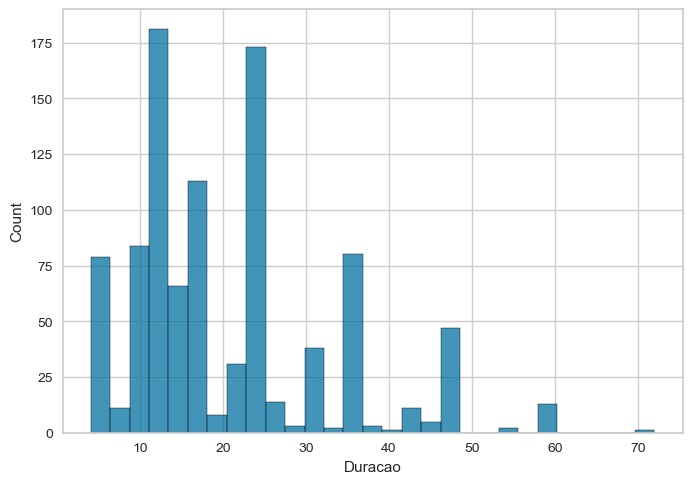

In [148]:
srn.histplot(data=credito, x='Duracao')

In [149]:
valor = credito.groupby(['Valor']).size()
valor

Valor
250      1
276      1
338      1
339      1
343      1
        ..
15653    1
15672    1
15857    1
15945    1
18424    1
Length: 892, dtype: int64

<Axes: xlabel='Valor', ylabel='Count'>

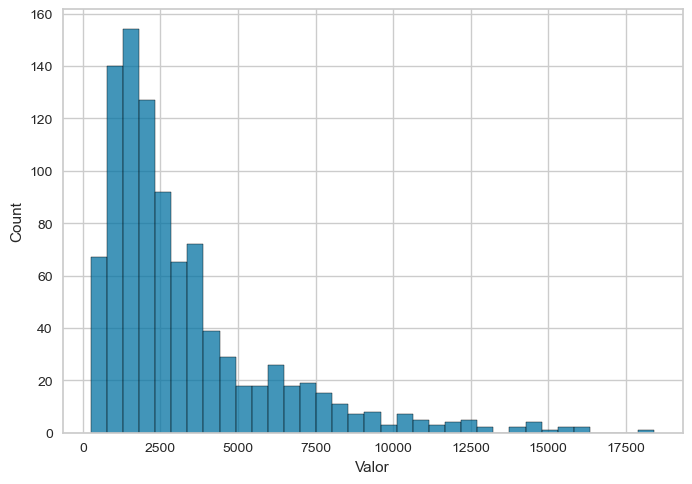

In [150]:
srn.histplot(data = credito, x = 'Valor')

In [151]:
tempo_parc = credito.groupby(['TempoParcelamento']).size()
tempo_parc

TempoParcelamento
1    135
2    224
3    152
4    455
dtype: int64

<Axes: xlabel='TempoParcelamento', ylabel='count'>

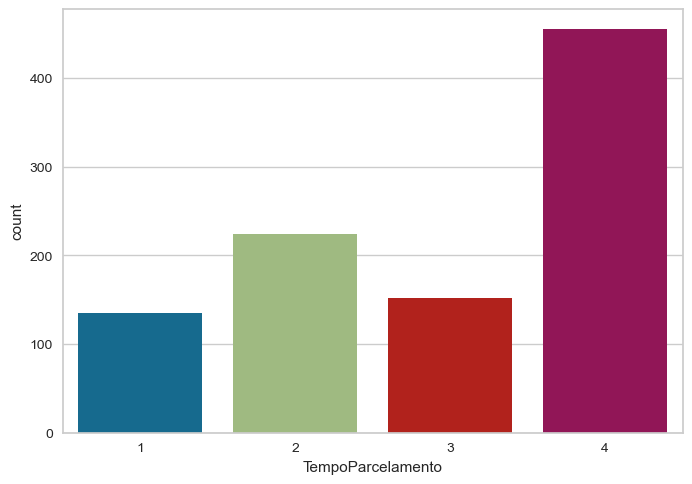

In [152]:
srn.countplot(data = credito, x = 'TempoParcelamento')

In [153]:
residencia_desde = credito.groupby(['ResidenciaDesde']).size()
residencia_desde


ResidenciaDesde
1.0    127
2.0    296
3.0    144
4.0    399
dtype: int64

<Axes: xlabel='ResidenciaDesde', ylabel='count'>

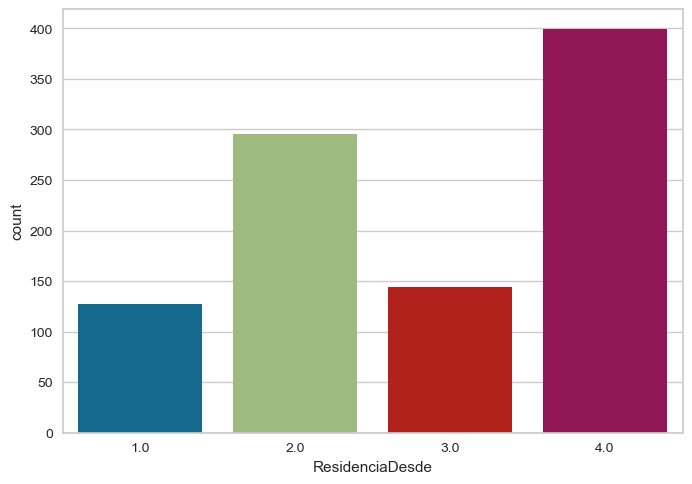

In [154]:
srn.countplot(data = credito, x = 'ResidenciaDesde')

In [155]:
idade = credito.groupby(['Idade']).size()
idade


Idade
19     2
20    14
21    14
22    27
23    46
24    42
25    38
26    48
27    51
28    42
29    37
30    38
31    36
32    32
33    31
34    32
35    37
36    37
37    27
38    24
39    21
40    25
41    17
42    21
43    17
44    17
45    15
46    17
47    17
48    12
49    14
50    11
51     7
52     9
53     7
54     8
55     8
56     3
57     8
58     4
59     3
60     6
61     7
62     2
63     8
64     5
65     5
66     5
67     2
68     3
70     1
74     4
75     2
dtype: int64

<Axes: xlabel='Idade', ylabel='Count'>

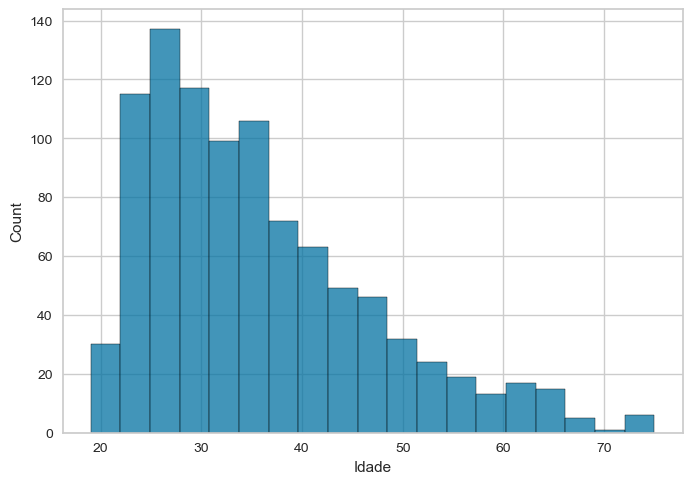

In [156]:
srn.histplot(data = credito, x = 'Idade')

In [157]:
dependentes = credito.groupby(['Dependentes']).size()
dependentes

Dependentes
1    814
2    152
dtype: int64

<Axes: xlabel='Dependentes', ylabel='count'>

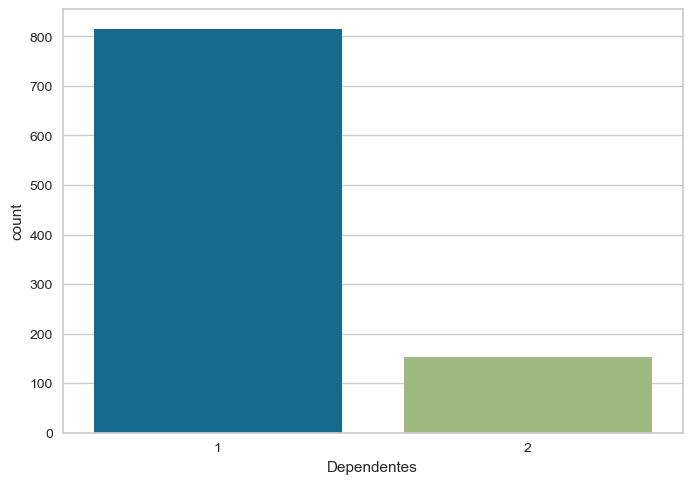

In [158]:
srn.countplot(data = credito, x = 'Dependentes')

In [159]:
socio = credito.groupby(['SocioEmpresa']).size()
socio


SocioEmpresa
0    579
1    387
dtype: int64

<Axes: xlabel='SocioEmpresa', ylabel='count'>

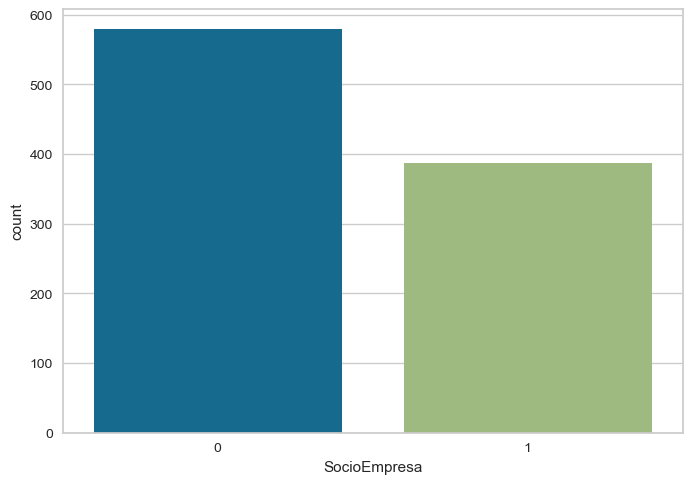

In [160]:
srn.countplot(data = credito, x = 'SocioEmpresa')

In [161]:
estrangeiro = credito.groupby(['Estrangeiro']).size()
estrangeiro

Estrangeiro
0    930
1     36
dtype: int64

<Axes: xlabel='Estrangeiro', ylabel='count'>

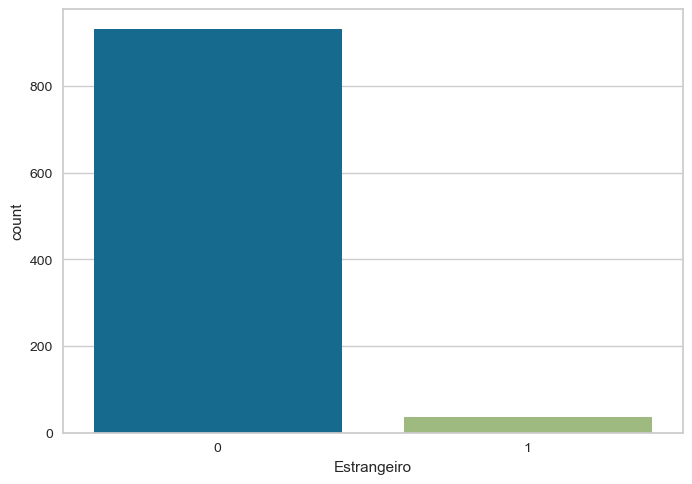

In [162]:
srn.countplot(data = credito, x = 'Estrangeiro')

In [163]:
status = credito.groupby(['Status']).size()
status

Status
0    294
1    672
dtype: int64

<Axes: xlabel='Status', ylabel='count'>

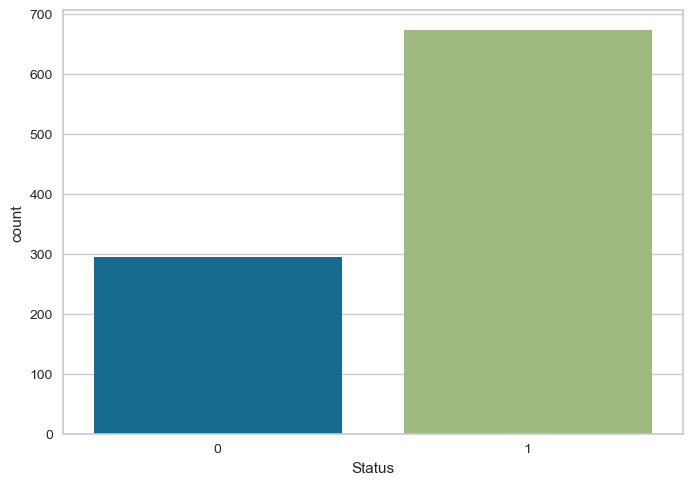

In [164]:
srn.countplot(data = credito, x = 'Status')

In [165]:
historico = credito.groupby(['HISTORICO']).size()
historico

HISTORICO
Atrasos anteriores           83
Critico-outros creditos     285
existentes/pagos            511
sem creditos/todos pagos     40
todos pagos                  47
dtype: int64

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'existentes/pagos'),
  Text(1, 0, 'Critico-outros creditos'),
  Text(2, 0, 'Atrasos anteriores'),
  Text(3, 0, 'sem creditos/todos pagos'),
  Text(4, 0, 'todos pagos')])

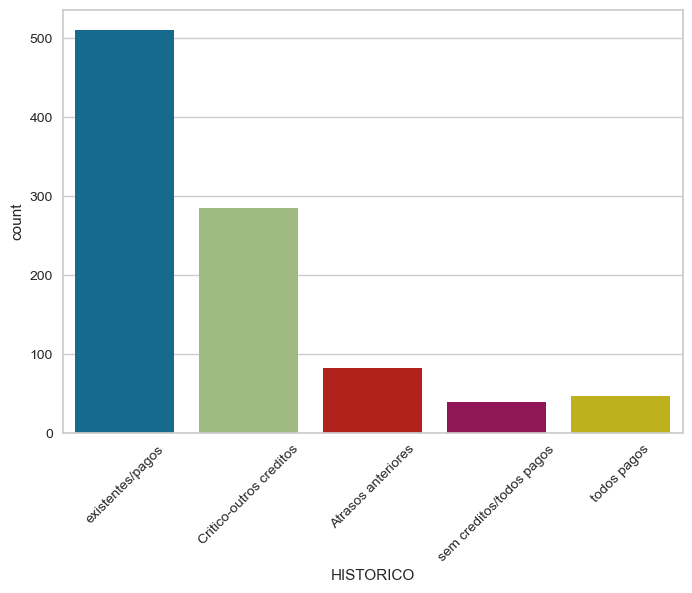

In [166]:
srn.countplot(data = credito, x = 'HISTORICO')
plt.xticks(rotation=45)


In [167]:
proposito = credito.groupby(['PROPOSITO']).size()
proposito

PROPOSITO
abrir negocio     94
educacao          48
moveis           175
outros            12
qualificacao       8
quitar divida     12
reforma          270
reforma casa      22
veiculo novo     228
veiculo usado     97
dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'reforma'),
  Text(1, 0, 'educacao'),
  Text(2, 0, 'moveis'),
  Text(3, 0, 'veiculo novo'),
  Text(4, 0, 'abrir negocio'),
  Text(5, 0, 'veiculo usado'),
  Text(6, 0, 'quitar divida'),
  Text(7, 0, 'reforma casa'),
  Text(8, 0, 'outros'),
  Text(9, 0, 'qualificacao')])

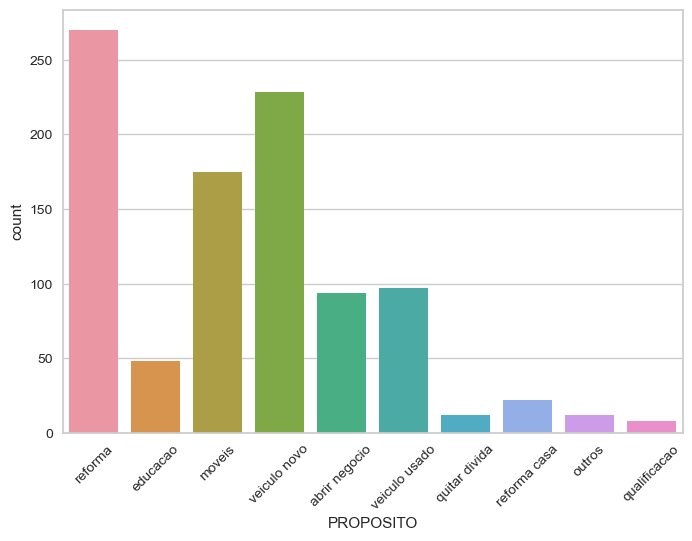

In [168]:
srn.countplot(data = credito, x = 'PROPOSITO')
plt.xticks(rotation=45)


In [169]:
credito_encoded = pd.get_dummies(credito, columns=['PROPOSITO'], drop_first=True)
proposito = credito.groupby(['PROPOSITO']).size()
proposito

PROPOSITO
abrir negocio     94
educacao          48
moveis           175
outros            12
qualificacao       8
quitar divida     12
reforma          270
reforma casa      22
veiculo novo     228
veiculo usado     97
dtype: int64

In [170]:
investimentos = credito.groupby(['INVESTIMENTOS']).size()
print(investimentos)

INVESTIMENTOS
100<=X<500        100
500<=X<1000        62
<100\n            584
>=1000             47
Desconhecido\n    173
dtype: int64


<Axes: xlabel='INVESTIMENTOS', ylabel='count'>

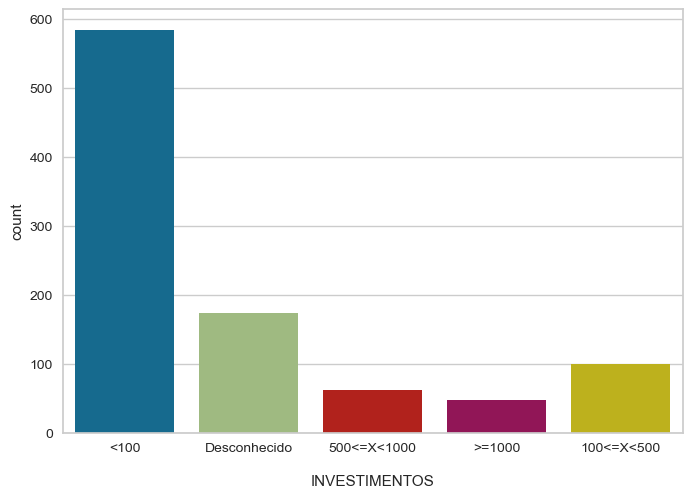

In [171]:
srn.countplot(data = credito, x = 'INVESTIMENTOS')

In [172]:
emprego = credito.groupby(['EMPREGO']).size()
print(emprego)

EMPREGO
1<=X<4          332
4<=X<7          164
<1              167
>=7             244
Desempregado     59
dtype: int64


<Axes: xlabel='EMPREGO', ylabel='count'>

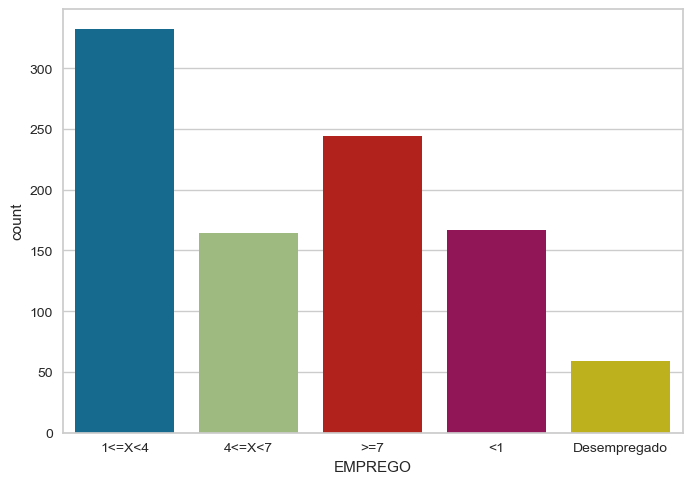

In [173]:
srn.countplot(data = credito, x = 'EMPREGO')

In [174]:
estado_civil = credito.groupby(['ESTADOCIVIL']).size()
estado_civil

ESTADOCIVIL
feminino div/dep/cas    301
maculino div/dep         50
masculino cas/viu        88
masculino solteiro      527
dtype: int64

<Axes: xlabel='ESTADOCIVIL', ylabel='count'>

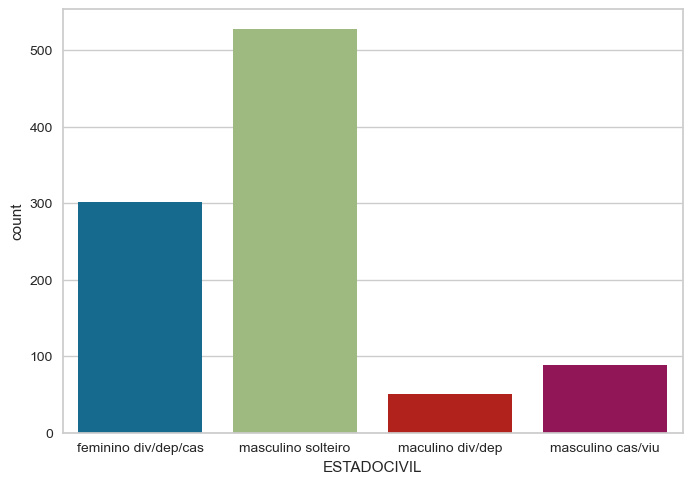

In [175]:
srn.countplot(data = credito, x = 'ESTADOCIVIL')

In [176]:
fiador = credito.groupby(['FIADOR']).size()
fiador

FIADOR
co aplicante       1
co requerente     39
nao              879
sim               47
dtype: int64

<Axes: xlabel='FIADOR', ylabel='count'>

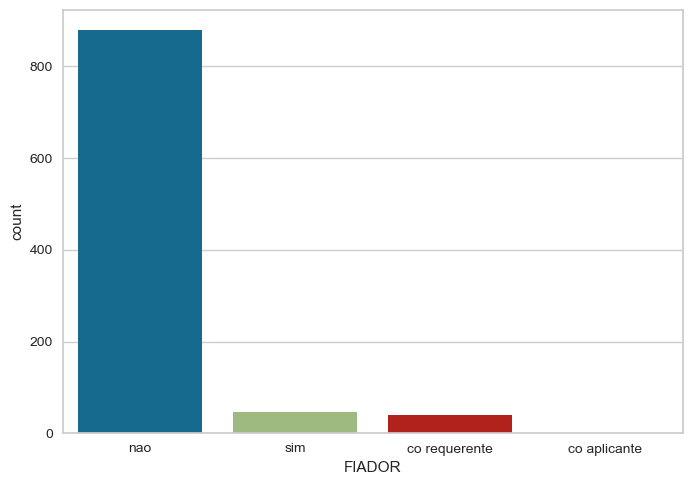

In [177]:
srn.countplot(data = credito, x = 'FIADOR')

In [178]:
outros_finan = credito.groupby(['OUTROSFINANCIAMENTOS']).size()
outros_finan

OUTROSFINANCIAMENTOS
banco     136
loja       42
nenhum    788
dtype: int64

<Axes: xlabel='OUTROSFINANCIAMENTOS', ylabel='count'>

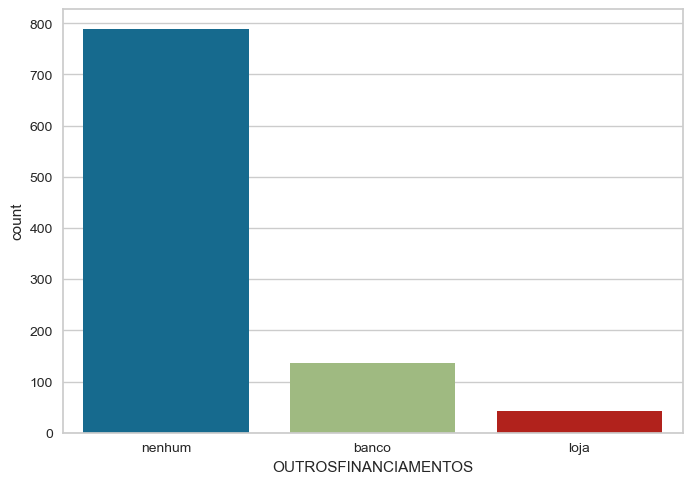

In [179]:
srn.countplot(data = credito, x = 'OUTROSFINANCIAMENTOS')

In [180]:
habitacao = credito.groupby(['HABITACAO']).size()
habitacao

HABITACAO
alugada     172
de graca    104
proria      690
dtype: int64

<Axes: xlabel='HABITACAO', ylabel='count'>

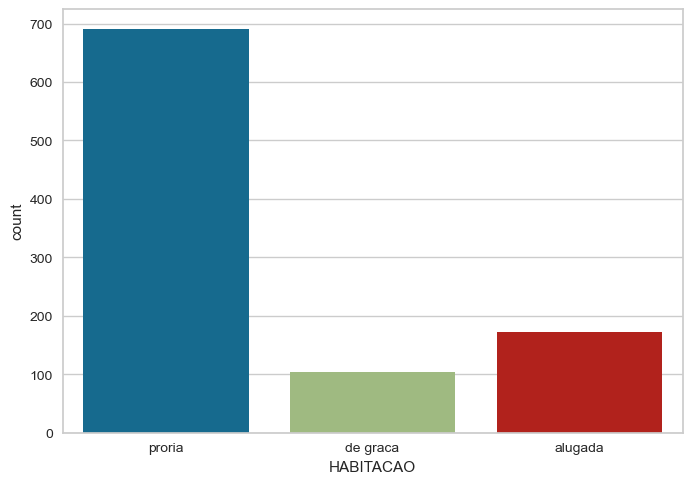

In [181]:
srn.countplot(data = credito, x = 'HABITACAO')

In [182]:
profissao = credito.groupby(['PROFISSAO']).size()
print(profissao)

PROFISSAO
altamente qualificado/empresario    139
desempregado                         22
nao qualificado                     194
qualificado                         611
dtype: int64


(array([0, 1, 2, 3]),
 [Text(0, 0, 'qualificado'),
  Text(1, 0, 'nao qualificado'),
  Text(2, 0, 'altamente qualificado/empresario'),
  Text(3, 0, 'desempregado')])

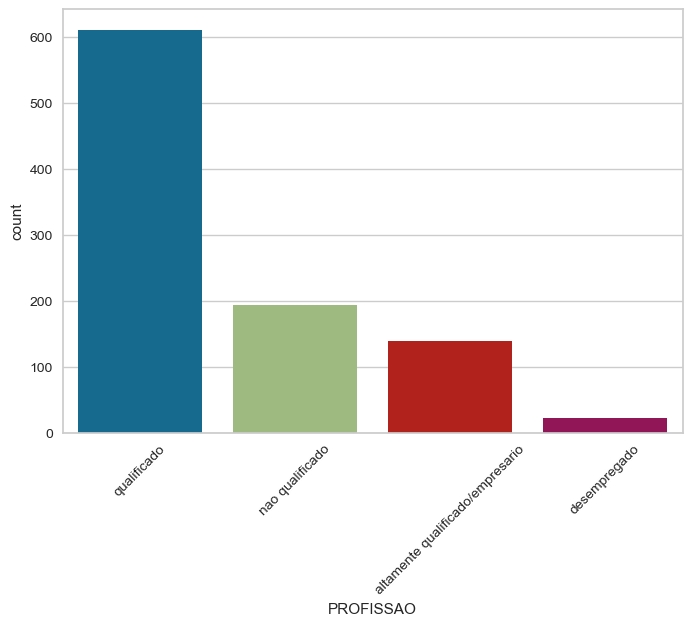

In [183]:
srn.countplot(data = credito, x = 'PROFISSAO')
plt.xticks(rotation=45)


In [184]:
credito = replace_outliers_with_mode(credito, ['Duracao', 'Valor', 'Idade'])

In [185]:
categorias = ['PROPOSITO', 'ESTADOCIVIL', 'FIADOR',  
             'OUTROSFINANCIAMENTOS', 'HABITACAO', 'HISTORICO' ]

credito_encoded = credito.copy() # Começa com uma cópia do dataframe original

for categoria in categorias:
    credito_encoded = pd.get_dummies(data = credito_encoded, columns=[categoria], drop_first=True)

credito_encoded

,Duracao,Valor,TempoParcelamento,ResidenciaDesde,Idade,Dependentes,SocioEmpresa,Estrangeiro,Status,INVESTIMENTOS,EMPREGO,PROFISSAO,PROPOSITO_educacao,PROPOSITO_moveis,PROPOSITO_outros,PROPOSITO_qualificacao,PROPOSITO_quitar divida,PROPOSITO_reforma,PROPOSITO_reforma casa,PROPOSITO_veiculo novo,PROPOSITO_veiculo usado,ESTADOCIVIL_maculino div/dep,ESTADOCIVIL_masculino cas/viu,ESTADOCIVIL_masculino solteiro,FIADOR_co requerente,FIADOR_nao,FIADOR_sim,OUTROSFINANCIAMENTOS_loja,OUTROSFINANCIAMENTOS_nenhum,HABITACAO_de graca,HABITACAO_proria,HISTORICO_Critico-outros creditos,HISTORICO_existentes/pagos,HISTORICO_sem creditos/todos pagos,HISTORICO_todos pagos
0,12,5951,2,2.0,22,1,0,0,0,<100\n,1<=X<4,qualificado,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0
1,12,2096,2,3.0,49,2,0,0,1,<100\n,4<=X<7,nao qualificado,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0
2,42,1262,2,4.0,45,2,0,0,1,<100\n,4<=X<7,qualificado,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,1,0,0
3,24,4870,3,4.0,53,2,0,0,0,<100\n,1<=X<4,qualificado,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0
4,36,1262,2,4.0,35,2,1,0,1,Desconhecido\n,1<=X<4,nao qualificado,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,15,1403,2,4.0,28,1,0,0,1,<100\n,1<=X<4,qualificado,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
962,18,4297,4,4.0,40,1,1,0,0,<100\n,>=7,altamente qualificado/empresario,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0
963,36,1977,4,4.0,40,1,1,0,0,Desconhecido\n,>=7,altamente qualificado/empresario,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0
964,9,1136,4,4.0,32,2,0,0,0,>=1000,>=7,qualificado,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0


In [186]:
#mapeamento manual para codificação das variáveis cujas ordens são relevantes
mapeamento = {
    'desempregado': 0,
    'nao qualificado': 1,
    'qualificado': 2,
    'altamente qualificado/empresario': 3
}

credito_encoded['PROFISSAO'] = credito_encoded['PROFISSAO'].map(mapeamento)
profissao = credito_encoded.groupby(['PROFISSAO']).size()
print(profissao)


PROFISSAO
0     22
1    194
2    611
3    139
dtype: int64


In [187]:
mapeamento = {
    'Desempregado': 0,
    '<1': 1,
    '1<=X<4': 2,
    '4<=X<7': 3,
    '>=7': 4
}

credito_encoded['EMPREGO'] = credito_encoded['EMPREGO'].map(mapeamento)
emprego = credito_encoded.groupby(['EMPREGO']).size()
print(emprego)


EMPREGO
0     59
1    167
2    332
3    164
4    244
dtype: int64


In [188]:
mapeamento = {
    'Desconhecido\n': 0,
    '<100\n': 1,
    '100<=X<500': 2,
    '500<=X<1000': 3,
    '>=1000': 4,

}

credito_encoded['INVESTIMENTOS'] = credito_encoded['INVESTIMENTOS'].map(mapeamento)
investimento = credito_encoded.groupby(['INVESTIMENTOS']).size()
print(investimento)


INVESTIMENTOS
0    173
1    584
2    100
3     62
4     47
dtype: int64


In [189]:
credito_encoded

,Duracao,Valor,TempoParcelamento,ResidenciaDesde,Idade,Dependentes,SocioEmpresa,Estrangeiro,Status,INVESTIMENTOS,EMPREGO,PROFISSAO,PROPOSITO_educacao,PROPOSITO_moveis,PROPOSITO_outros,PROPOSITO_qualificacao,PROPOSITO_quitar divida,PROPOSITO_reforma,PROPOSITO_reforma casa,PROPOSITO_veiculo novo,PROPOSITO_veiculo usado,ESTADOCIVIL_maculino div/dep,ESTADOCIVIL_masculino cas/viu,ESTADOCIVIL_masculino solteiro,FIADOR_co requerente,FIADOR_nao,FIADOR_sim,OUTROSFINANCIAMENTOS_loja,OUTROSFINANCIAMENTOS_nenhum,HABITACAO_de graca,HABITACAO_proria,HISTORICO_Critico-outros creditos,HISTORICO_existentes/pagos,HISTORICO_sem creditos/todos pagos,HISTORICO_todos pagos
0,12,5951,2,2.0,22,1,0,0,0,1,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0
1,12,2096,2,3.0,49,2,0,0,1,1,3,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0
2,42,1262,2,4.0,45,2,0,0,1,1,3,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,1,0,0
3,24,4870,3,4.0,53,2,0,0,0,1,2,2,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0
4,36,1262,2,4.0,35,2,1,0,1,0,2,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,15,1403,2,4.0,28,1,0,0,1,1,2,2,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
962,18,4297,4,4.0,40,1,1,0,0,1,4,3,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0
963,36,1977,4,4.0,40,1,1,0,0,0,4,3,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0
964,9,1136,4,4.0,32,2,0,0,0,4,4,2,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0


In [190]:
#Checando novamente a quantidade de NaNs
credito.isnull().sum()

Duracao                 0
Valor                   0
TempoParcelamento       0
ResidenciaDesde         0
Idade                   0
Dependentes             0
SocioEmpresa            0
Estrangeiro             0
Status                  0
HISTORICO               0
PROPOSITO               0
INVESTIMENTOS           0
EMPREGO                 0
ESTADOCIVIL             0
FIADOR                  0
OUTROSFINANCIAMENTOS    0
HABITACAO               0
PROFISSAO               0
dtype: int64

In [191]:
# Lista das colunas sem 'status'
cols = [col for col in credito_encoded.columns if col != 'Status']

# Adiciona 'status' ao final da lista
cols.append('Status')

# Reordena as colunas do DataFrame para melhor separação entre previsores e classe
credito_encoded = credito_encoded[cols]
credito_encoded

,Duracao,Valor,TempoParcelamento,ResidenciaDesde,Idade,Dependentes,SocioEmpresa,Estrangeiro,INVESTIMENTOS,EMPREGO,PROFISSAO,PROPOSITO_educacao,PROPOSITO_moveis,PROPOSITO_outros,PROPOSITO_qualificacao,PROPOSITO_quitar divida,PROPOSITO_reforma,PROPOSITO_reforma casa,PROPOSITO_veiculo novo,PROPOSITO_veiculo usado,ESTADOCIVIL_maculino div/dep,ESTADOCIVIL_masculino cas/viu,ESTADOCIVIL_masculino solteiro,FIADOR_co requerente,FIADOR_nao,FIADOR_sim,OUTROSFINANCIAMENTOS_loja,OUTROSFINANCIAMENTOS_nenhum,HABITACAO_de graca,HABITACAO_proria,HISTORICO_Critico-outros creditos,HISTORICO_existentes/pagos,HISTORICO_sem creditos/todos pagos,HISTORICO_todos pagos,Status
0,12,5951,2,2.0,22,1,0,0,1,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0
1,12,2096,2,3.0,49,2,0,0,1,3,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1
2,42,1262,2,4.0,45,2,0,0,1,3,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,1,0,0,1
3,24,4870,3,4.0,53,2,0,0,1,2,2,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0
4,36,1262,2,4.0,35,2,1,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,15,1403,2,4.0,28,1,0,0,1,2,2,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1
962,18,4297,4,4.0,40,1,1,0,1,4,3,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
963,36,1977,4,4.0,40,1,1,0,0,4,3,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0
964,9,1136,4,4.0,32,2,0,0,4,4,2,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0


In [192]:
duracao_media = credito_encoded['Duracao'].mean()
valor_media = credito_encoded['Valor'].mean()
taxa_juros_mensal = 0.0766

print(f"Média da duração: {duracao_media}")
print(f"Média do valor: {valor_media}")


Média da duração: 18.098343685300208
Média do valor: 2550.150103519669


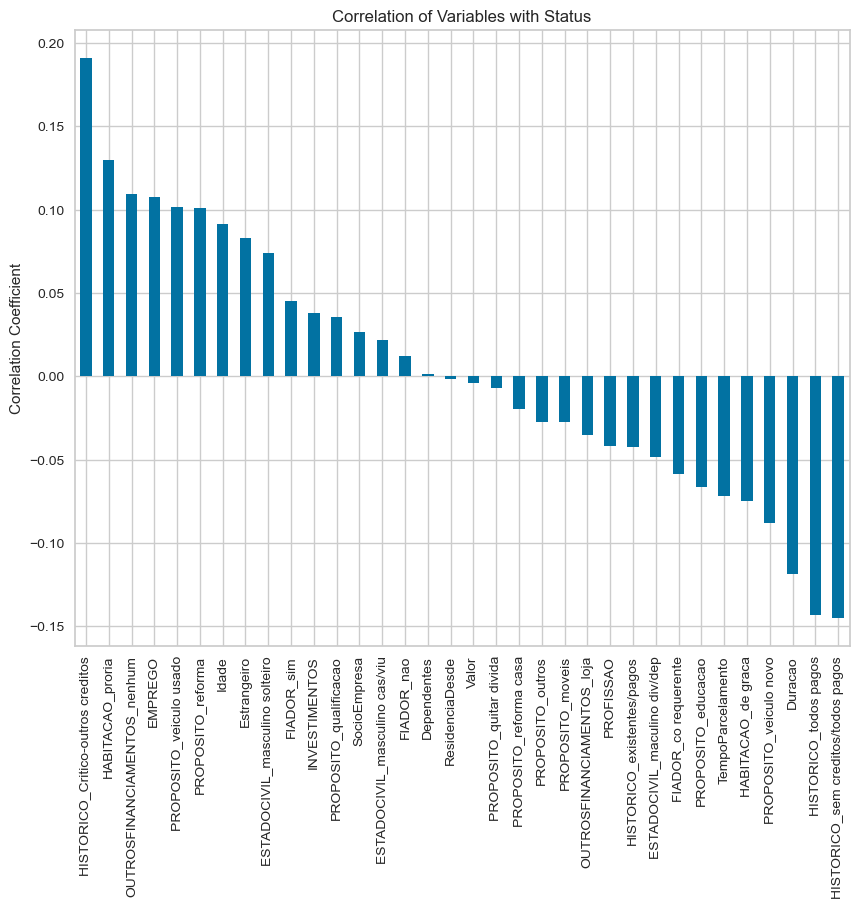

In [193]:
correlations_status = credito_encoded.corr()['Status'].sort_values(ascending=False)
plt.figure(figsize=(10,8))
correlations_status.drop('Status').plot(kind='bar')  # Excluímos a correlação de 'status' com ele mesmo
plt.title('Correlation of Variables with Status')
plt.ylabel('Correlation Coefficient')
plt.show()



In [194]:
# Formato de matriz para criação do primeiro modelo com todas as variáveis
#1° MODELO
previsores = credito_encoded.iloc[:,0:33].values
classe = credito_encoded.iloc[:,33].values


In [195]:
# Divisão da base de dados entre treinamento e teste (30% para testar e 70% para treinar)
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(previsores,
                                                                  classe,
                                                                  test_size = 0.3,
                                                                  random_state = 0)

In [196]:
# Criação do modelo, treinamento, obtenção das previsões e da taxa de acerto
floresta = RandomForestClassifier(n_estimators = 300)
floresta.fit(X_treinamento, y_treinamento)

RandomForestClassifier(n_estimators=300)

In [197]:
# Visualização dos atributos principais
#floresta.estimators_
floresta.estimators_[1]

DecisionTreeClassifier(max_features='sqrt', random_state=1860965835)

In [198]:
previsoes = floresta.predict(X_teste)
confusao = confusion_matrix(y_teste, previsoes)
taxa_acerto = accuracy_score(y_teste, previsoes)
taxa_acerto

0.9482758620689655

In [199]:
confusao

array([[274,   0],
       [ 15,   1]], dtype=int64)

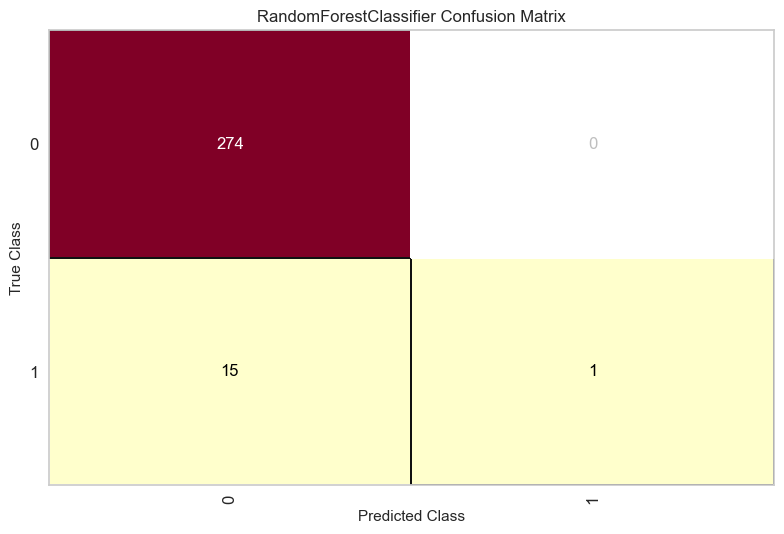

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [200]:
# Visualização da matriz de confusão
# Warning interno da biblioteca yellowbrick, já esta na última versão (sem solução para o warning no momento)
v = ConfusionMatrix(RandomForestClassifier())
v.fit(X_treinamento, y_treinamento)
v.score(X_teste, y_teste)
v.poof()

In [201]:
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       274
           1       1.00      0.06      0.12        16

    accuracy                           0.95       290
   macro avg       0.97      0.53      0.55       290
weighted avg       0.95      0.95      0.93       290



In [202]:
#Cálculo das perdas médias financeiras a partir dos resultados
# A matriz de confusão é assim:
# [[maus-corretos, bons-incorretos],
#  [maus-incorretos, bons-corretos]]

resultados = {}

maus_incorretos = confusao[1][0]
bons_incorretos = confusao[0][1]
bons_corretos = confusao[1][1]

# Calculando o prejuízo devido a calotes
valor_calote = bons_incorretos * valor_media

# Calculando o prejuízo devido à perda de juros
valor_final = valor_media * (1 + taxa_juros_mensal)**duracao_media
prejuizo_juros = (valor_final - valor_media) * maus_incorretos

# Prejuízo total
prejuizo_total = valor_calote + prejuizo_juros

# Lucro de juros recebidos por cada bom pagador
lucro_por_bom_pagador = (valor_final - valor_media)

# Lucro total devido aos bons pagadores corretos
lucro_juros_bons = lucro_por_bom_pagador * bons_corretos

# Lucro total do modelo
lucro_total = lucro_juros_bons - prejuizo_total

resultados['decision_tree_completo'] = {'prejuizo': prejuizo_total, 'lucro': lucro_total}


print(f"Prejuízo devido a inadimplência: {valor_calote}")
print(f"Prejuízo devido à perda de juros: {prejuizo_juros}")
print(f"Prejuízo total: {prejuizo_total}")
print(f"Lucro devido aos juros recebidos dos bons pagadores: {lucro_juros_bons}")
print(f"Lucro total do modelo: {lucro_total}")


Prejuízo devido a inadimplência: 0.0
Prejuízo devido à perda de juros: 107222.6617859527
Prejuízo total: 107222.6617859527
Lucro devido aos juros recebidos dos bons pagadores: 7148.177452396847
Lucro total do modelo: -100074.48433355585


In [203]:
# Criação e treinamento do modelo (geração da tabela de probabilidades)
# 2° MODELO
naive_bayes = GaussianNB()
naive_bayes.fit(X_treinamento, y_treinamento)

GaussianNB()

In [204]:
# Previsões utilizando os registros de teste
previsoes = naive_bayes.predict(X_teste)
previsoes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0], dtype=uint8)

In [205]:
#geração da matriz de confusão e cálculo da taxa de acerto e erro
confusao = confusion_matrix(y_teste, previsoes)
confusao

array([[258,  16],
       [  3,  13]], dtype=int64)

In [206]:
taxa_acerto = accuracy_score(y_teste, previsoes)
taxa_erro = 1 - taxa_acerto
taxa_acerto

0.9344827586206896

##### Visualização da matriz de confusão
# Warning interno da biblioteca yellowbrick, já esta na última versão (sem solução para o warning no momento)
v = ConfusionMatrix(GaussianNB())
v.fit(X_treinamento, y_treinamento)
v.score(X_teste, y_teste)
v.poof()

In [207]:
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       274
           1       0.45      0.81      0.58        16

    accuracy                           0.93       290
   macro avg       0.72      0.88      0.77       290
weighted avg       0.96      0.93      0.94       290



In [208]:
#Cálculo das perdas médias financeiras a partir dos resultados
# A matriz de confusão é assim:
# [[maus-corretos, bons-incorretos],
#  [maus-incorretos, bons-corretos]]

maus_incorretos = confusao[1][0]
bons_incorretos = confusao[0][1]
bons_corretos = confusao[1][1]


# Calculando o prejuízo devido a calotes
valor_calote = bons_incorretos * valor_media

# Calculando o prejuízo devido à perda de juros
valor_final = valor_media * (1 + taxa_juros_mensal)**duracao_media
prejuizo_juros = (valor_final - valor_media) * maus_incorretos

# Prejuízo total
prejuizo_total = valor_calote + prejuizo_juros

# Lucro de juros recebidos por cada bom pagador
lucro_por_bom_pagador = (valor_final - valor_media)

# Lucro total devido aos bons pagadores corretos
lucro_juros_bons = lucro_por_bom_pagador * bons_corretos

# Lucro total do modelo
lucro_total = lucro_juros_bons - prejuizo_total

resultados['naive_bayes_completo'] = {'prejuizo': prejuizo_total, 'lucro': lucro_total}

print(f"Prejuízo devido a inadimplência: {valor_calote}")
print(f"Prejuízo devido à perda de juros: {prejuizo_juros}")
print(f"Prejuízo total: {prejuizo_total}")
print(f"Lucro devido aos juros recebidos dos bons pagadores: {lucro_juros_bons}")
print(f"Lucro total do modelo: {lucro_total}")

Prejuízo devido a inadimplência: 40802.4016563147
Prejuízo devido à perda de juros: 21444.53235719054
Prejuízo total: 62246.93401350524
Lucro devido aos juros recebidos dos bons pagadores: 92926.306881159
Lucro total do modelo: 30679.372867653765


In [210]:
# Carregamento da base de dados e criação dos previsores (variáveis independentes - X) e da classe (variável dependente - y)
# 3° MODELO - REDES NEURAIS
# Criação da estrutura da rede neural com a classe Sequential (sequência de camadas)
modelo = Sequential()
#primeira camada oculta, 5 neuronios, 4 neuronios de entrada
modelo.add(Dense(units = 5, input_dim = 33))
#segunda camada oculta
modelo.add(Dense(units = 4))
# Função softmax porque temos um problema de classificação com mais de duas classes 
#(é gerada uma probabilidade em cada neurônio)
modelo.add(Dense(units = 1, activation = 'sigmoid'))

In [211]:
# Configuração dos parâmetros da rede neural (adam = algoritmo para atualizar os pesos e loss = cálculo do erro)
modelo.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Treinamento, dividindo a base de treinamento em uma porção para validação (validation_data)
modelo.fit(X_treinamento, y_treinamento, epochs = 500,
           validation_data = (X_teste, y_teste))



Epoch 1/500
22/22 [==============================] - 2s 25ms/step - loss: 44.4268 - accuracy: 0.9541 - val_loss: 30.5550 - val_accuracy: 0.9448
Epoch 2/500
22/22 [==============================] - 0s 10ms/step - loss: 34.8447 - accuracy: 0.9541 - val_loss: 22.9456 - val_accuracy: 0.9448
Epoch 3/500
22/22 [==============================] - 0s 9ms/step - loss: 25.6817 - accuracy: 0.9541 - val_loss: 16.3407 - val_accuracy: 0.9448
Epoch 4/500
22/22 [==============================] - 0s 10ms/step - loss: 17.3330 - accuracy: 0.9541 - val_loss: 9.9908 - val_accuracy: 0.9448
Epoch 5/500
22/22 [==============================] - 0s 9ms/step - loss: 9.6472 - accuracy: 0.9467 - val_loss: 3.4270 - val_accuracy: 0.9276
Epoch 6/500
22/22 [==============================] - 0s 10ms/step - loss: 3.3658 - accuracy: 0.8107 - val_loss: 2.3653 - val_accuracy: 0.7621
Epoch 7/500
22/22 [==============================] - 0s 10ms/step - loss: 3.1291 - accuracy: 0.8639 - val_loss: 2.1479 - val_accuracy: 0.7448
E

In [212]:
# Previsões e mudar a variável para True ou False de acordo com o threshold 0.5
previsoes = modelo.predict(X_teste)
previsoes = (previsoes > 0.5)


10/10 [==============================] - 0s 5ms/step


In [213]:
# Geração da matriz de confusão
confusao = confusion_matrix(y_teste, previsoes)
confusao

array([[274,   0],
       [ 13,   3]], dtype=int64)

In [214]:
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       274
           1       1.00      0.19      0.32        16

    accuracy                           0.96       290
   macro avg       0.98      0.59      0.65       290
weighted avg       0.96      0.96      0.94       290



In [215]:
#Cálculo das perdas médias financeiras a partir dos resultados
# A matriz de confusão é assim:
# [[maus-corretos, bons-incorretos],
#  [maus-incorretos, bons-corretos]]

maus_incorretos = confusao[1][0]
bons_incorretos = confusao[0][1]
bons_corretos = confusao[1][1]


# Calculando o prejuízo devido a calotes
valor_calote = bons_incorretos * valor_media

# Calculando o prejuízo devido à perda de juros
valor_final = valor_media * (1 + taxa_juros_mensal)**duracao_media
prejuizo_juros = (valor_final - valor_media) * maus_incorretos

# Prejuízo total
prejuizo_total = valor_calote + prejuizo_juros

# Lucro de juros recebidos por cada bom pagador
lucro_por_bom_pagador = (valor_final - valor_media)

# Lucro total devido aos bons pagadores corretos
lucro_juros_bons = lucro_por_bom_pagador * bons_corretos

# Lucro total do modelo
lucro_total = lucro_juros_bons - prejuizo_total

resultados['neural_network_completo'] = {'prejuizo': prejuizo_total, 'lucro': lucro_total}

print(f"Prejuízo devido a inadimplência: {valor_calote}")
print(f"Prejuízo devido à perda de juros: {prejuizo_juros}")
print(f"Prejuízo total: {prejuizo_total}")
print(f"Lucro devido aos juros recebidos dos bons pagadores: {lucro_juros_bons}")
print(f"Lucro total do modelo: {lucro_total}")

Prejuízo devido a inadimplência: 0.0
Prejuízo devido à perda de juros: 92926.306881159
Prejuízo total: 92926.306881159
Lucro devido aos juros recebidos dos bons pagadores: 21444.53235719054
Lucro total do modelo: -71481.77452396846


In [216]:
#Testagem dos modelos com menos previsores
#As colunas selecionadas foram escolhidas com base no gráfico de correlações
#Correlações maiores ou iguais a |0,1|
colunas_selecionadas = [
    'HISTORICO_Critico-outros creditos',
    'HISTORICO_existentes/pagos',
    'HISTORICO_sem creditos/todos pagos',
    'HISTORICO_sem creditos/todos pagos',
    'HABITACAO_proria',
    'HABITACAO_de graca',
    'Duracao',
    'EMPREGO',
    'OUTROSFINANCIAMENTOS_nenhum',
    'OUTROSFINANCIAMENTOS_loja'
]

# Selecionando as colunas desejadas
previsores = credito_encoded[colunas_selecionadas].values

In [217]:
# Divisão da base de dados entre treinamento e teste (30% para testar e 70% para treinar)
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(previsores,
                                                                  classe,
                                                                  test_size = 0.3,
                                                                  random_state = 0)

In [218]:
# Criação do modelo, treinamento, obtenção das previsões e da taxa de acerto
#4° MODELO - agora com menos previsores
floresta = RandomForestClassifier(n_estimators = 300)
floresta.fit(X_treinamento, y_treinamento)

RandomForestClassifier(n_estimators=300)

In [219]:
# Visualização dos atributos principais
#floresta.estimators_
floresta.estimators_[1]

DecisionTreeClassifier(max_features='sqrt', random_state=324302414)

In [220]:
previsoes = floresta.predict(X_teste)
confusao = confusion_matrix(y_teste, previsoes)
taxa_acerto = accuracy_score(y_teste, previsoes)
taxa_acerto

0.9586206896551724

In [221]:
confusao

array([[272,   2],
       [ 10,   6]], dtype=int64)

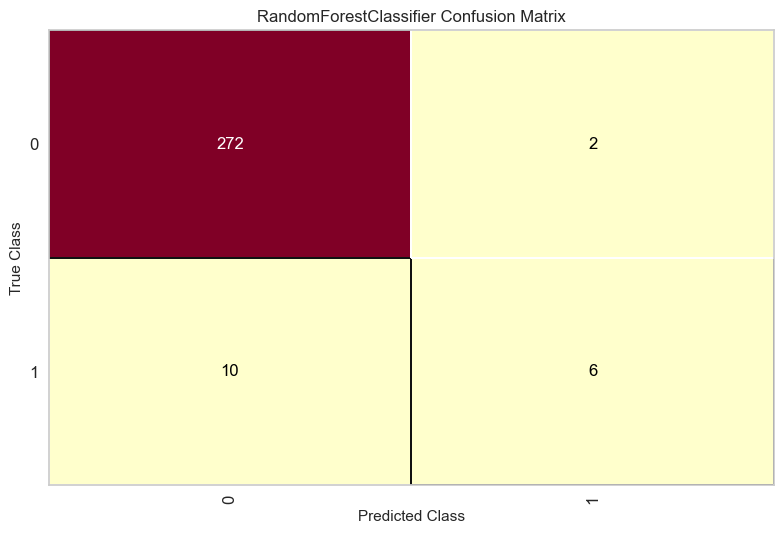

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [223]:
# Visualização da matriz de confusão
# Warning interno da biblioteca yellowbrick, já esta na última versão (sem solução para o warning no momento)
v = ConfusionMatrix(RandomForestClassifier())
v.fit(X_treinamento, y_treinamento)
v.score(X_teste, y_teste)
v.poof()

In [224]:
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       274
           1       0.75      0.38      0.50        16

    accuracy                           0.96       290
   macro avg       0.86      0.68      0.74       290
weighted avg       0.95      0.96      0.95       290



In [225]:
#Cálculo das perdas médias financeiras a partir dos resultados
# A matriz de confusão é assim:
# [[maus-corretos, bons-incorretos],
#  [maus-incorretos, bons-corretos]]

maus_incorretos = confusao[1][0]
bons_incorretos = confusao[0][1]
bons_corretos = confusao[1][1]


# Calculando o prejuízo devido a calotes
valor_calote = bons_incorretos * valor_media

# Calculando o prejuízo devido à perda de juros
valor_final = valor_media * (1 + taxa_juros_mensal)**duracao_media
prejuizo_juros = (valor_final - valor_media) * maus_incorretos

# Prejuízo total
prejuizo_total = valor_calote + prejuizo_juros

# Lucro de juros recebidos por cada bom pagador
lucro_por_bom_pagador = (valor_final - valor_media)

# Lucro total devido aos bons pagadores corretos
lucro_juros_bons = lucro_por_bom_pagador * bons_corretos

# Lucro total do modelo
lucro_total = lucro_juros_bons - prejuizo_total

resultados['decision_tree_ajustado'] = {'prejuizo': prejuizo_total, 'lucro': lucro_total}

print(f"Prejuízo devido a inadimplência: {valor_calote}")
print(f"Prejuízo devido à perda de juros: {prejuizo_juros}")
print(f"Prejuízo total: {prejuizo_total}")
print(f"Lucro devido aos juros recebidos dos bons pagadores: {lucro_juros_bons}")
print(f"Lucro total do modelo: {lucro_total}")

Prejuízo devido a inadimplência: 5100.300207039338
Prejuízo devido à perda de juros: 71481.77452396847
Prejuízo total: 76582.07473100781
Lucro devido aos juros recebidos dos bons pagadores: 42889.06471438108
Lucro total do modelo: -33693.01001662674


In [226]:
# Criação e treinamento do modelo (geração da tabela de probabilidades)
# 5° MODELO
naive_bayes = GaussianNB()
naive_bayes.fit(X_treinamento, y_treinamento)

GaussianNB()

In [227]:
# Previsões utilizando os registros de teste
previsoes = naive_bayes.predict(X_teste)
previsoes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0], dtype=uint8)

In [228]:
taxa_acerto = accuracy_score(y_teste, previsoes)
taxa_erro = 1 - taxa_acerto
taxa_acerto

0.9344827586206896

In [229]:
confusao = confusion_matrix(y_teste, previsoes)
confusao

array([[255,  19],
       [  0,  16]], dtype=int64)

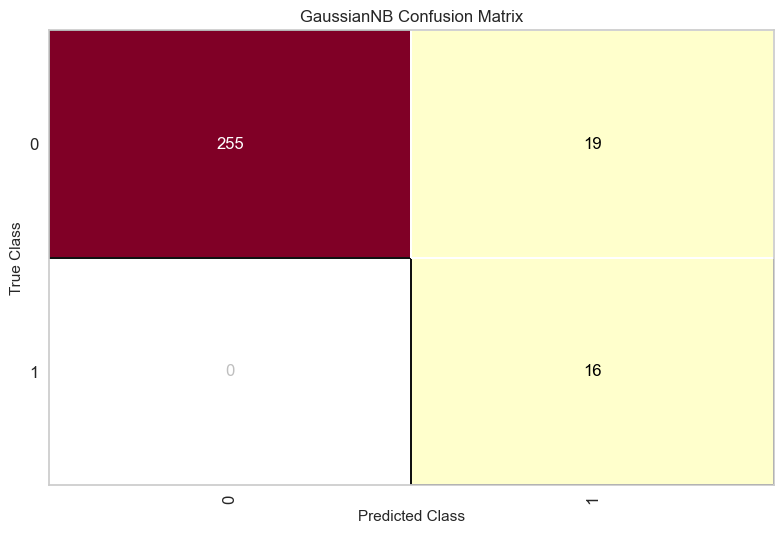

<Axes: title={'center': 'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [230]:
# Visualização da matriz de confusão
# Warning interno da biblioteca yellowbrick, já esta na última versão (sem solução para o warning no momento)
v = ConfusionMatrix(GaussianNB())
v.fit(X_treinamento, y_treinamento)
v.score(X_teste, y_teste)
v.poof()

In [231]:
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       274
           1       0.46      1.00      0.63        16

    accuracy                           0.93       290
   macro avg       0.73      0.97      0.80       290
weighted avg       0.97      0.93      0.95       290



In [232]:
#Cálculo das perdas médias financeiras a partir dos resultados
# A matriz de confusão é assim:
# [[maus-corretos, bons-incorretos],
#  [maus-incorretos, bons-corretos]]

maus_incorretos = confusao[1][0]
bons_incorretos = confusao[0][1]
bons_corretos = confusao[1][1]


# Calculando o prejuízo devido a calotes
valor_calote = bons_incorretos * valor_media

# Calculando o prejuízo devido à perda de juros
valor_final = valor_media * (1 + taxa_juros_mensal)**duracao_media
prejuizo_juros = (valor_final - valor_media) * maus_incorretos

# Prejuízo total
prejuizo_total = valor_calote + prejuizo_juros

# Lucro de juros recebidos por cada bom pagador
lucro_por_bom_pagador = (valor_final - valor_media)

# Lucro total devido aos bons pagadores corretos
lucro_juros_bons = lucro_por_bom_pagador * bons_corretos

# Lucro total do modelo
lucro_total = lucro_juros_bons - prejuizo_total

resultados['naive_bayes_ajustado'] = {'prejuizo': prejuizo_total, 'lucro': lucro_total}

print(f"Prejuízo devido a inadimplência: {valor_calote}")
print(f"Prejuízo devido à perda de juros: {prejuizo_juros}")
print(f"Prejuízo total: {prejuizo_total}")
print(f"Lucro devido aos juros recebidos dos bons pagadores: {lucro_juros_bons}")
print(f"Lucro total do modelo: {lucro_total}")

Prejuízo devido a inadimplência: 48452.851966873706
Prejuízo devido à perda de juros: 0.0
Prejuízo total: 48452.851966873706
Lucro devido aos juros recebidos dos bons pagadores: 114370.83923834955
Lucro total do modelo: 65917.98727147584


In [233]:
# Carregamento da base de dados e criação dos previsores (variáveis independentes - X) e da classe (variável dependente - y)
# 6° MODELO - REDES NEURAIS
# Criação da estrutura da rede neural com a classe Sequential (sequência de camadas)
modelo = Sequential()
#primeira camada oculta, 5 neuronios, 4 neuronios de entrada
modelo.add(Dense(units = 5, input_dim = 10))
#segunda camada oculta
modelo.add(Dense(units = 4))
# Função softmax porque temos um problema de classificação com mais de duas classes 
#(é gerada uma probabilidade em cada neurônio)
modelo.add(Dense(units = 1, activation = 'sigmoid'))

In [234]:
# Configuração dos parâmetros da rede neural (adam = algoritmo para atualizar os pesos e loss = cálculo do erro)
modelo.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Treinamento, dividindo a base de treinamento em uma porção para validação (validation_data)
modelo.fit(X_treinamento, y_treinamento, epochs = 500,
           validation_data = (X_teste, y_teste))

Epoch 1/500
22/22 [==============================] - 2s 25ms/step - loss: 3.7716 - accuracy: 0.0784 - val_loss: 2.0624 - val_accuracy: 0.1862
Epoch 2/500
22/22 [==============================] - 0s 10ms/step - loss: 1.2008 - accuracy: 0.4527 - val_loss: 0.5633 - val_accuracy: 0.7138
Epoch 3/500
22/22 [==============================] - 0s 9ms/step - loss: 0.4140 - accuracy: 0.8151 - val_loss: 0.3156 - val_accuracy: 0.8655
Epoch 4/500
22/22 [==============================] - 0s 9ms/step - loss: 0.2998 - accuracy: 0.9038 - val_loss: 0.2625 - val_accuracy: 0.9000
Epoch 5/500
22/22 [==============================] - 0s 9ms/step - loss: 0.2692 - accuracy: 0.9201 - val_loss: 0.2438 - val_accuracy: 0.9138
Epoch 6/500
22/22 [==============================] - 0s 9ms/step - loss: 0.2562 - accuracy: 0.9231 - val_loss: 0.2323 - val_accuracy: 0.9276
Epoch 7/500
22/22 [==============================] - 0s 10ms/step - loss: 0.2476 - accuracy: 0.9305 - val_loss: 0.2243 - val_accuracy: 0.9310
Epoch 8/50

In [235]:
# Previsões e mudar a variável para True ou False de acordo com o threshold 0.5
previsoes = modelo.predict(X_teste)
previsoes = (previsoes > 0.5)

10/10 [==============================] - 0s 4ms/step


In [236]:
# Geração da matriz de confusão
confusao = confusion_matrix(y_teste, previsoes)
confusao

array([[269,   5],
       [  6,  10]], dtype=int64)

In [237]:
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       274
           1       0.67      0.62      0.65        16

    accuracy                           0.96       290
   macro avg       0.82      0.80      0.81       290
weighted avg       0.96      0.96      0.96       290



In [238]:
#Cálculo das perdas médias financeiras a partir dos resultados
# A matriz de confusão é assim:
# [[maus-corretos, bons-incorretos],
#  [maus-incorretos, bons-corretos]]

maus_incorretos = confusao[1][0]
bons_incorretos = confusao[0][1]
bons_corretos = confusao[1][1]


# Calculando o prejuízo devido a calotes
valor_calote = bons_incorretos * valor_media

# Calculando o prejuízo devido à perda de juros
valor_final = valor_media * (1 + taxa_juros_mensal)**duracao_media
prejuizo_juros = (valor_final - valor_media) * maus_incorretos

# Prejuízo total
prejuizo_total = valor_calote + prejuizo_juros

# Lucro de juros recebidos por cada bom pagador
lucro_por_bom_pagador = (valor_final - valor_media)

# Lucro total devido aos bons pagadores corretos
lucro_juros_bons = lucro_por_bom_pagador * bons_corretos

# Lucro total do modelo
lucro_total = lucro_juros_bons - prejuizo_total

resultados['neural_network_ajustado'] = {'prejuizo': prejuizo_total, 'lucro': lucro_total}


print(f"Prejuízo devido a inadimplência: {valor_calote}")
print(f"Prejuízo devido à perda de juros: {prejuizo_juros}")
print(f"Prejuízo total: {prejuizo_total}")
print(f"Lucro devido aos juros recebidos dos bons pagadores: {lucro_juros_bons}")
print(f"Lucro total do modelo: {lucro_total}")

Prejuízo devido a inadimplência: 12750.750517598344
Prejuízo devido à perda de juros: 42889.06471438108
Prejuízo total: 55639.815231979424
Lucro devido aos juros recebidos dos bons pagadores: 71481.77452396847
Lucro total do modelo: 15841.95929198905


In [241]:
df_resultados = pd.DataFrame(resultados).T.reset_index()
df_resultados.columns = ['Modelo', 'Prejuizo', 'Lucro']
df_resultados.to_excel('resultados_modelos.xlsx', index=False)

In [120]:
""""No projeto final do curso, recebi um banco de dados de uma empresa especializada em empréstimos. Atualmente, essa empresa enfrenta uma taxa de inadimplência de 30%. Fui contratado com o objetivo principal de reduzir essa porcentagem para pelo menos 25%.

Após os devidos tratamentos de dados, desenvolvi seis modelos preditivos. Embora esses modelos apresentem taxas de acerto semelhantes, eles identificam inadimplentes com alta precisão. No entanto, alguns são excessivamente conservadores, o que significa que eles tendem a classificar indevidamente bons clientes como inadimplentes.

Método de Avaliação:

1. Inadimplentes Incorrectamente Classificados como Bons Pagadores: Multiplicando o número de inadimplentes por valor médio dos empréstimos, estimei o prejuízo potencial.

2. Bons Pagadores Incorretamente Classificados: Para aqueles que foram negados erroneamente, calculei a perda de receita com base no juro composto que a empresa deixou de receber.

3. Lucro Potencial: Para os bons pagadores corretamente identificados, determinei o lucro baseando-me no total de juros recebidos menos o prejuízo total.

Resultados:

- Modelo 1: Prejuízo: 107222.66, Lucro: -100074.48, Inadimplência: 0%
- Modelo 2: Prejuízo: 62246.93, Lucro: 30679.37, Inadimplência: 5,5%
- Modelo 3: Prejuízo: 92926.30, Lucro: -71481.77, Inadimplência: 0%
- Modelo 4: Prejuízo: 81682.37, Lucro: -38793.31, Inadimplência: 1%
- Modelo 5: Prejuízo: 48452.85, Lucro: 65917.98, Inadimplência: 6,5%
- Modelo 6: Prejuízo: 55639.81, Lucro: 15841.95, Inadimplência: 1,7%

Note que a taxa de inadimplência de cada modelo foi calculada considerando a proporção de "bons-incorretos" (inadimplentes classificados como bons pagadores) em relação aos 290 clientes do conjunto de teste.

Dado o objetivo estabelecido de reduzir a taxa de inadimplência para pelo menos 25% e os resultados acima, o Modelo 5 parece ser o mais promissor. Ele não apenas apresenta o menor prejuízo, mas também oferece o maior lucro e tem uma taxa de inadimplência aceitável de 6,5%."""

'"No projeto final do curso, recebi um banco de dados de uma empresa especializada em empréstimos. Atualmente, essa empresa enfrenta uma taxa de inadimplência de 30%. Fui contratado com o objetivo principal de reduzir essa porcentagem para pelo menos 25%.\n\nApós os devidos tratamentos de dados, desenvolvi seis modelos preditivos. Embora esses modelos apresentem taxas de acerto semelhantes, eles identificam inadimplentes com alta precisão. No entanto, alguns são excessivamente conservadores, o que significa que eles tendem a classificar indevidamente bons clientes como inadimplentes.\n\nMétodo de Avaliação:\n\n1. Inadimplentes Incorrectamente Classificados como Bons Pagadores: Multiplicando o número de inadimplentes por valor médio dos empréstimos, estimei o prejuízo potencial.\n\n2. Bons Pagadores Incorretamente Classificados: Para aqueles que foram negados erroneamente, calculei a perda de receita com base no juro composto que a empresa deixou de receber.\n\n3. Lucro Potencial: Para 